检查环境，pytorch & cuda，colab已经预装了。

In [1]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 1.12.1+cu102
CUDA available: True
CUDA version: 10.2


# Preliminary API

## torch.nn.Linear(input_feat, out_feat)

得搞清楚nn.Linear()，来龙去脉

深度学习，仿射变换的公式一般是：

$$y=x*W^T+b$$

x.shape = (batch, len, d_model)

我给Linear的输入是(in_feat, out_feat)【注意，这不等于W的实际shape】

但是torch在构建实际的W的时候，实际的W.shape是（out_feat, in_feat）

然后再经过一次transpose（这一步是藏在functional里面的）又变成了（in，out）

[nn.Linear](https://github.com/pytorch/pytorch/blob/v2.6.0/torch/nn/modules/linear.py#L50)

torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)[source]
![Pytorch源码](img/Snipaste_2025-03-21_10-49-41.png)

[torch.nn.functional.linear](https://pytorch.org/docs/stable/generated/torch.nn.functional.linear.html#torch.nn.functional.linear)

torch.nn.functional.linear(input, weight, bias=None) → Tensor

In [2]:
import torch
import torch.nn as nn

W_qkv = nn.Linear(768, 3*768)
x = torch.randn(2, 256, 768)

print(W_qkv(x).shape)

torch.Size([2, 256, 2304])


## torch.split(tensor, split_size_or_sections, dim=0)

默认在dim0上做分割

中间给的splitsize可以是int也可以是列表

比如下面的例子里面给的就是【1，4】

就是把第一个维度5，分割成1和4两个

In [3]:
a = torch.arange(10).reshape(5, 2)
print(a)
print(torch.split(a, 2))
print(torch.split(a, [1, 4]))

tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7],
        [8, 9]])
(tensor([[0, 1],
        [2, 3]]), tensor([[4, 5],
        [6, 7]]), tensor([[8, 9]]))
(tensor([[0, 1]]), tensor([[2, 3],
        [4, 5],
        [6, 7],
        [8, 9]]))


emm 怎么和官网给的代码运行出来的结果不太一样呢？

官网说的是，假如这个分割不是整数倍，最后一个chunk会小一点，但是现在是第一个变小了，这么奇怪吗？

感觉最后一个变小，更加符合直觉一些。

## torch.polar(abs, angle, *, out=None)

将输入转换成复数形式，用于RoPE中freq_cis的precompute，下图有个笔误，z[1]的虚数部分幅度是2i，而不是i。

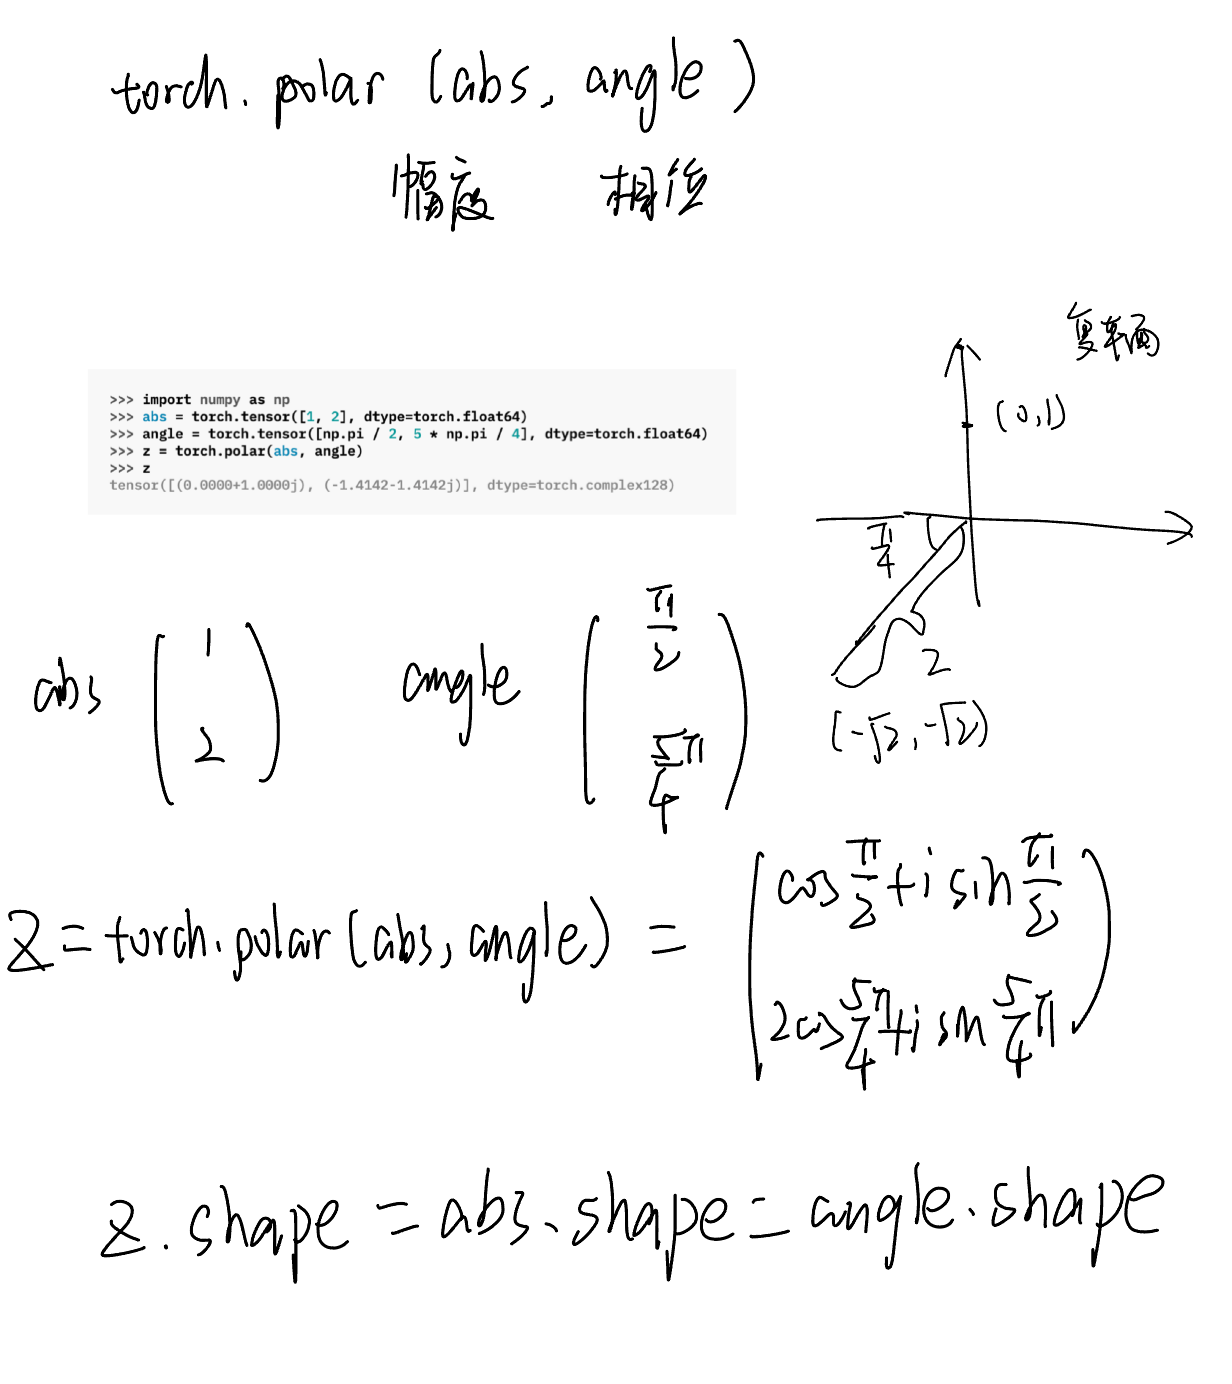

## torch.view_as_complex(input) & view_as_real(input)

view_as_complex 要求最后一个维度是2，只能是2，然后把【\*， 0】看作实部，【\*， 1】看作虚部。

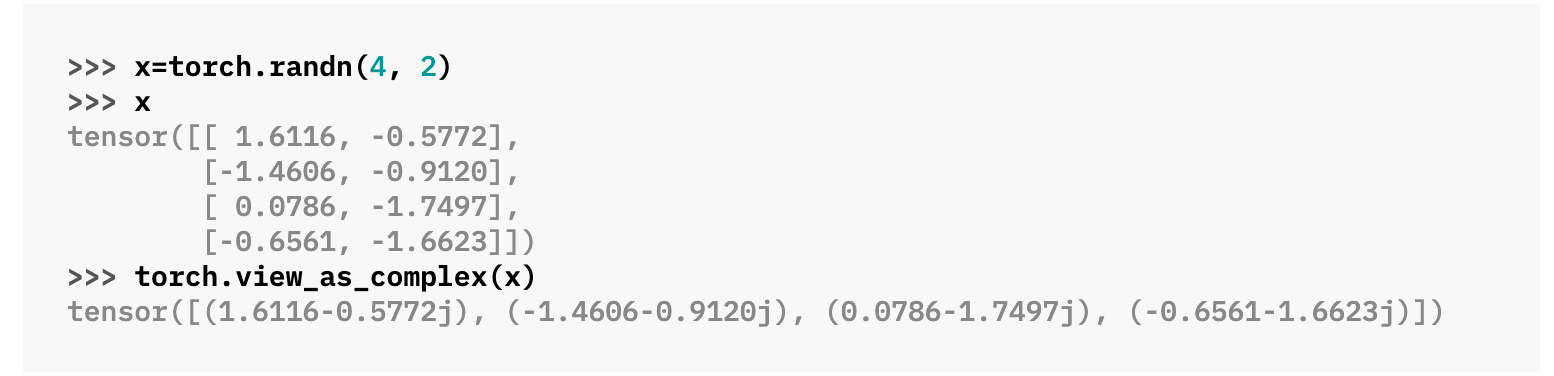

view_as_real 输入是复数，输出是实部虚部。

complex = torch.tensor([1+2j, 3+4j])

print(complex.view_as_real().shape)

\>\> 输出：torch.Size([2, 2])

## torch.Tensor.flatten(start_dim=0, end_dim=-1)

torch.Tensor.flatten 方法的功能是将张量的指定维度及其之后的所有维度进行展平操作，也就是把这些维度合并成一个维度。

# class MHA

In [4]:
import torch
import torch.nn as nn

class MHA (nn.Module):
  def __init__(self, d_model, num_heads):
    super(MHA, self).__init__()
    assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

    self.d_model = d_model
    self.num_heads = num_heads
    self.d_k = d_model // num_heads

    self.W_qkv = nn.Linear(d_model, 3*d_model)
    self.W_o = nn.Linear(d_model, d_model)

  def attention(self, query, key, value, mask = None):
    scores = torch.matmul(query, key.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32))
    if mask is not None:
      scores = scores.masked_fill(mask==0, 1e-9)
    p_attn = torch.softmax(scores, dim=-1)
    return torch.matmul(p_attn, value), p_attn

  def split_heads(self, x):
    batch, seqlength, d_model = x.size()
    # 想想为什么要交换维度呢？主要是将（batch,num_heads）放在前面，后面的（seqlength, d_k）是每个头上的qkv的shape
    return x.view(batch, seqlength, self.num_heads, self.d_k).transpose(1, 2)

  def combine_heads(self, x):
    batch, num_heads, seqlength, d_k = x.size()
    return x.transpose(1, 2).contiguous().view(batch, seqlength, d_model)

  def forward(self, x, mask=None):
    # nn.Linear Linear接受的参数是(in_feat， out_feat) x.shape = (b, l, d_model)
    # qkv.shape = (b, l, 3d_model)
    qkv = self.W_qkv(x)
    # split沿着最后一个维度拆分，每个都拆分成d_model大小
    Q, K, V = torch.split(qkv, self.d_model, dim=-1)

    # Q.shape = （batch，numheads，seqlength，dk）
    Q = self.split_heads(Q)
    K = self.split_heads(K)
    V = self.split_heads(V)

    x, attn = self.attention(Q, K, V)
    x = self.combine_heads(x)

    return self.W_o(x), attn

In [5]:
batch = 3
seqlength = 256
d_model = 768
num_heads = 8

mha = MHA(d_model, num_heads)

x = torch.randn(batch, seqlength, d_model)

output, attn = mha(x)

print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attn.shape}")

Output shape: torch.Size([3, 256, 768])
Attention weights shape: torch.Size([3, 8, 256, 256])


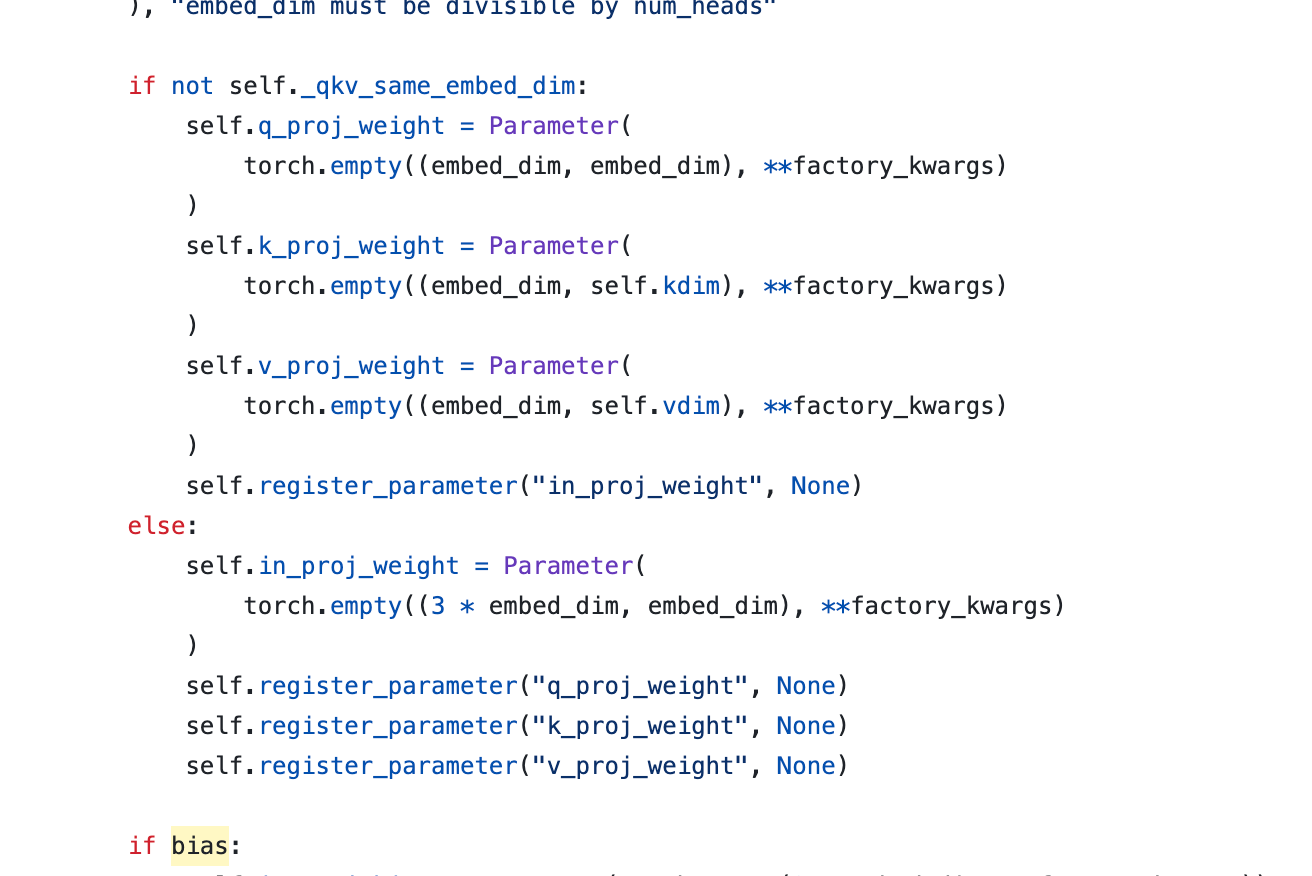

pytocrch内部也实现了qkv的嵌入，导致结果不能比对。

我需要把中间状态拿出来，调用属性，或者重写forward方法。

# class RoPE

## 原理

RoPE旋转位置编码，为什么叫旋转？因为结合了旋转矩阵。
![RoPE](../img/RoPE.jpg)

RoPE拓展到多维度的情况（而不再是二维的）意思就是对于一个维度为head_dim的向量，我们把它两两分成一组，每一组施加一个旋转矩阵，该旋转矩阵的角度会根据具体维度发生变化。（m cta0， m cta1， mcta2 ……）m代表token在seq中的id，cta代表角度，跟该组在head_dim中的位置有关。

注意这个$\theta$一定要记住，不然很难写代码
![RoPE2](../img/RoPE多维.png)

RoPE的高维度旋转矩阵有很多0，稀疏矩阵，直接做矩阵乘法效率太低，因此整理成新的方式：
![RoPE3](../img/RoPE稀疏整合版.png)

具体代码直接去看RoPE1.py就可以。

# class RMSNorm

$$ \text{RMSNorm}(x) = \frac{x}{\sqrt{\text{Mean}(x^2) + \epsilon}} \cdot \gamma $$

 $$ \text{LayerNorm}(x) = \frac{x - \text{Mean}(x)}{\sqrt{\text{Var}(x) + \epsilon}} \cdot \gamma + \beta $$
 

In [ ]:
class RMSNorm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super(RMSNorm, self).__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model)) # 可学习的权重参数
    def forward(self, x):
        norm = x.pow(2).mean(-1, keepdim=True) + self.eps   # 若不keepdim，则求均值的那个维度会消失，导致不能广播
        x = x * torch.rsqrt(norm)
        return self.weight * x